## TASK 3 Modify the function so that it obtains a different target distribution. Use a noiseless all-to-all sampler: ##

##  a. Exponential distribution ##

##  b. Hadamard quantum walk ##

In [5]:
%matplotlib inline
from qiskit import QuantumCircuit
from qiskit.circuit.library import CSwapGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit import transpile
import numpy as np

# a. Exponential distribution #

Figure(705.552x451.5)


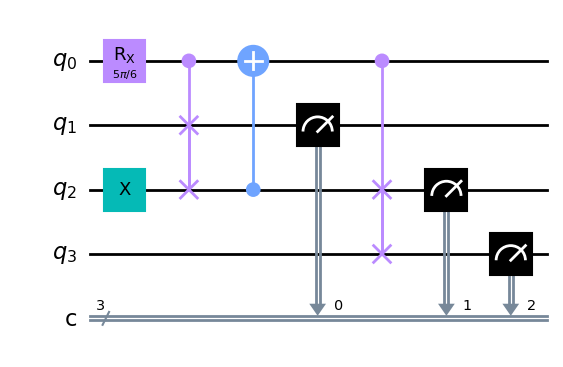

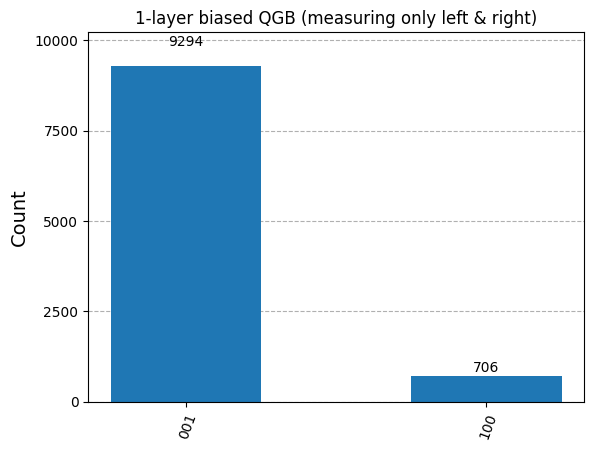

In [6]:

def one_layer_biased_qgb(theta):
    """
    Implements a one-layer biased quantum Galton board as in the provided circuit diagram.
    - theta: bias angle for Rx gate on the coin qubit.
    """
    qc = QuantumCircuit(4, 3)  # q0=coin, q1-q3=positions, 3 classical bits

    # Initialize ball at center position (q2)
    qc.x(2)
    # Initialize coin in |0> (already default)
    # Apply Rx(theta) to coin
    qc.rx(theta, 0)

    # Controlled-SWAP (coin, q1, q2)
    qc.append(CSwapGate(), [0, 1, 2])
    # CNOT (q2, coin)
    qc.cx(2, 0)
    # Controlled-SWAP (coin, q2, q3)
    qc.append(CSwapGate(), [0, 2, 3])

    # Measure position qubits
    qc.measure(1, 0)
    qc.measure(2, 1)
    qc.measure(3, 2)

    # Draw circuit in Clifford style
    print(qc.draw(output='mpl', style='clifford', fold=1))
    return qc

# Example usage:
qc = one_layer_biased_qgb(theta=5 * np.pi / 6)
    
# Simulate
sim = AerSimulator()
from qiskit import transpile
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=10000).result()
counts = result.get_counts()

# Show result
plot_histogram(counts)
plt.title("1-layer biased QGB (measuring only left & right)")
plt.show()

2 layer biased QGB

Figure(1625.27x618.722)


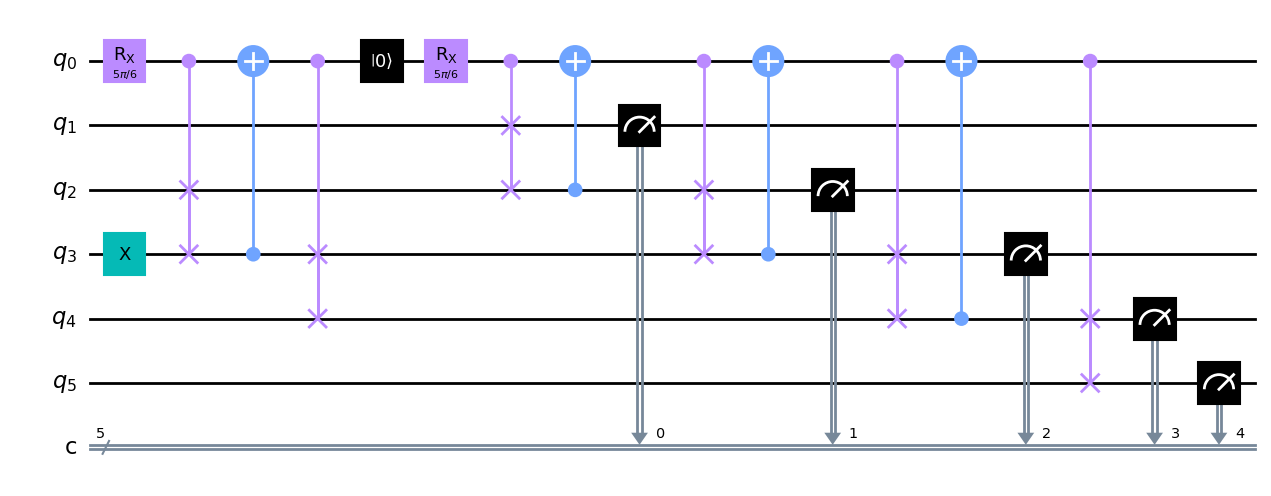

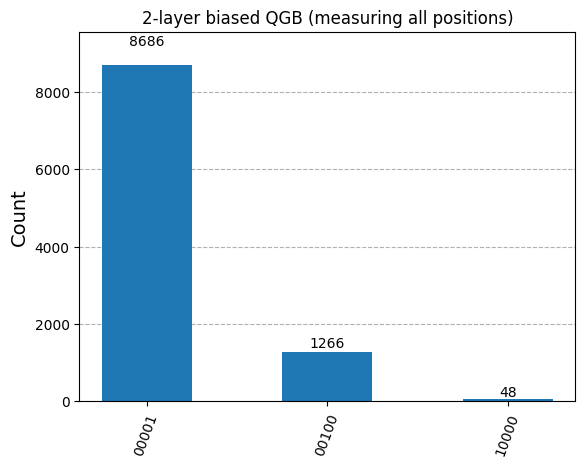

In [7]:
def two_layer_biased_qgb(theta):
    """
    Implements a two-layer biased quantum Galton board.
    - theta: bias angle for Rx gate on the coin qubit.
    """
    qc = QuantumCircuit(6, 5)  # q0=coin, q1-q5=positions, 5 classical bits

    # Initialize ball at center position (q3)
    qc.x(3)
    # Layer 1
    qc.rx(theta, 0)
    qc.append(CSwapGate(), [0, 2, 3])
    qc.cx(3, 0)
    qc.append(CSwapGate(), [0, 3, 4])

    # Reset coin to |0> before layer 2
    qc.reset(0)

    # Layer 2
    qc.rx(theta, 0)
    qc.append(CSwapGate(), [0, 1, 2])
    qc.cx(2, 0)
    qc.append(CSwapGate(), [0, 2, 3])
    qc.cx(3, 0)
    qc.append(CSwapGate(), [0, 3, 4])
    qc.cx(4, 0)
    qc.append(CSwapGate(), [0, 4, 5])

    # Measure position qubits
    qc.measure(1, 0)
    qc.measure(2, 1)
    qc.measure(3, 2)
    qc.measure(4, 3)
    qc.measure(5, 4)

    # Draw circuit in Clifford style
    print(qc.draw(output='mpl', style='clifford', fold=1))
    return qc

# Example usage:
qc = two_layer_biased_qgb(theta=5 * np.pi / 6)

# Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=10000).result()
counts = result.get_counts()

# Show result
plot_histogram(counts)
plt.title("2-layer biased QGB (measuring all positions)")
plt.show()

n layer biased QGB 

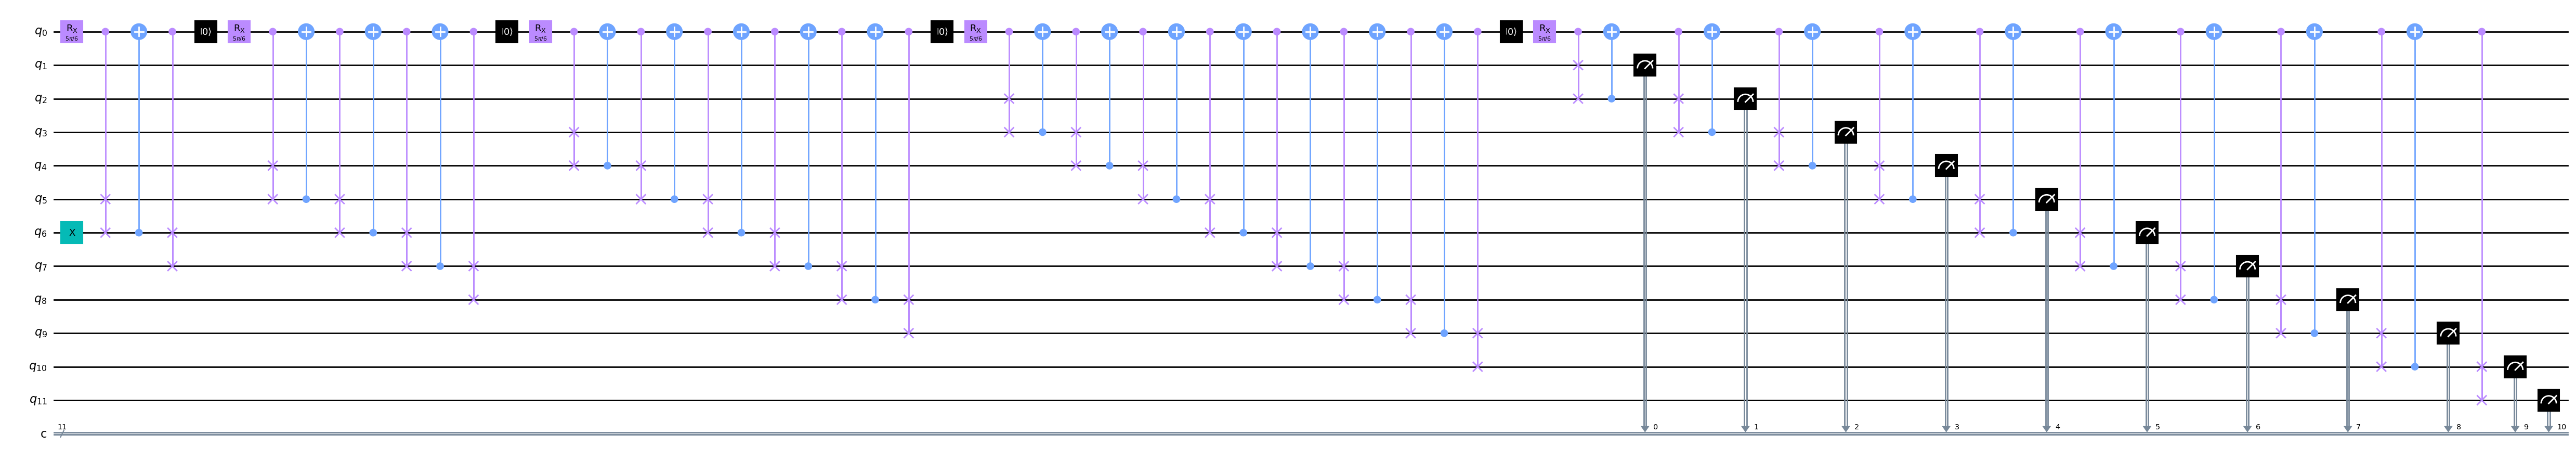

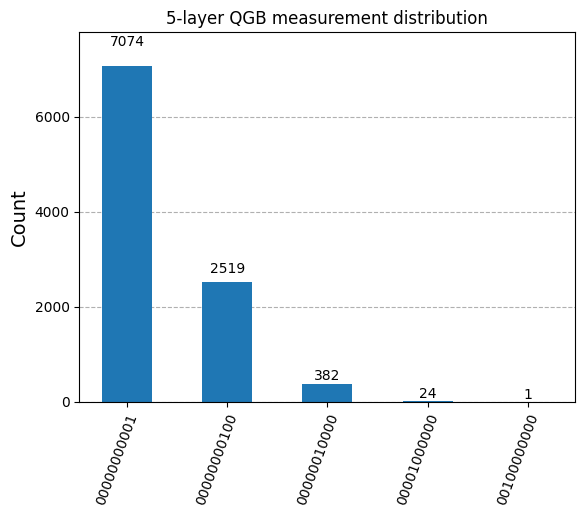

In [8]:
def n_layer_biased_qgb(n_layers, theta):
    """
    Implements an n-layer biased quantum Galton board.
    - n_layers: number of layers
    - theta: bias angle for Rx gate on the coin qubit.
    """
    num_positions = 2 * n_layers + 1
    total_qubits = num_positions + 1  # 1 coin + position qubits
    qc = QuantumCircuit(total_qubits, num_positions)

    coin = 0
    center = n_layers + 1  # q[index of center position]

    # Initialize ball at center
    qc.x(center)

    for k in range(1, n_layers + 1):
        qc.rx(theta, coin)
        # Pairs for this layer: (center-k) to (center+k-1)
        pairs = [(j, j + 1) for j in range(center - k, center + k)]
        for i, (a, b) in enumerate(pairs):
            qc.append(CSwapGate(), [coin, a, b])
            if i < len(pairs) - 1:
                qc.cx(b, coin)
        # Reset coin to |0> before next layer (unless last layer)
        if k < n_layers:
            qc.reset(coin)

    # Measure all position qubits
    for i, pos in enumerate(range(1, num_positions + 1)):
        qc.measure(pos, i)

    # Draw circuit in Clifford style
    qc.draw(output='mpl', style='clifford', fold=1)
    return qc

# Example usage:
n_layers = 5
qc = n_layer_biased_qgb(n_layers=n_layers, theta=5 * np.pi / 6)

# Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=10000).result()
counts = result.get_counts()

# Show result
plot_histogram(counts)
plt.title(f"{n_layers}-layer QGB measurement distribution")
plt.show()

Statistical Analysis of QGB Exponential Distribution

In [13]:
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

150° Biased QGB Analysis:
  Layers: 3
  Bias angle: 150° (5π/6 rad)
  Center index: 4

150° BIASED QGB RIGHT-TAIL EXPONENTIAL ANALYSIS
Layers: 3, Shots: 8192


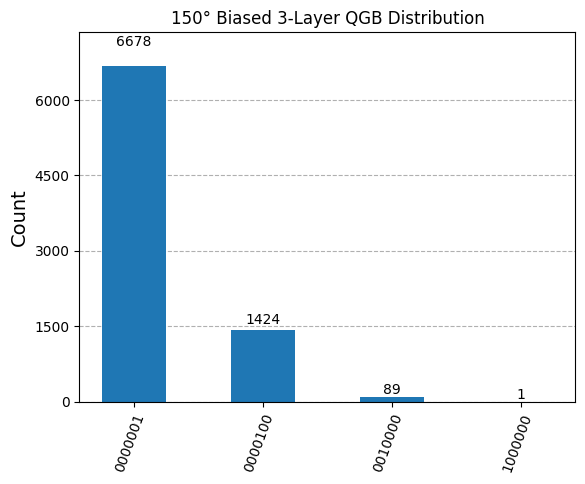

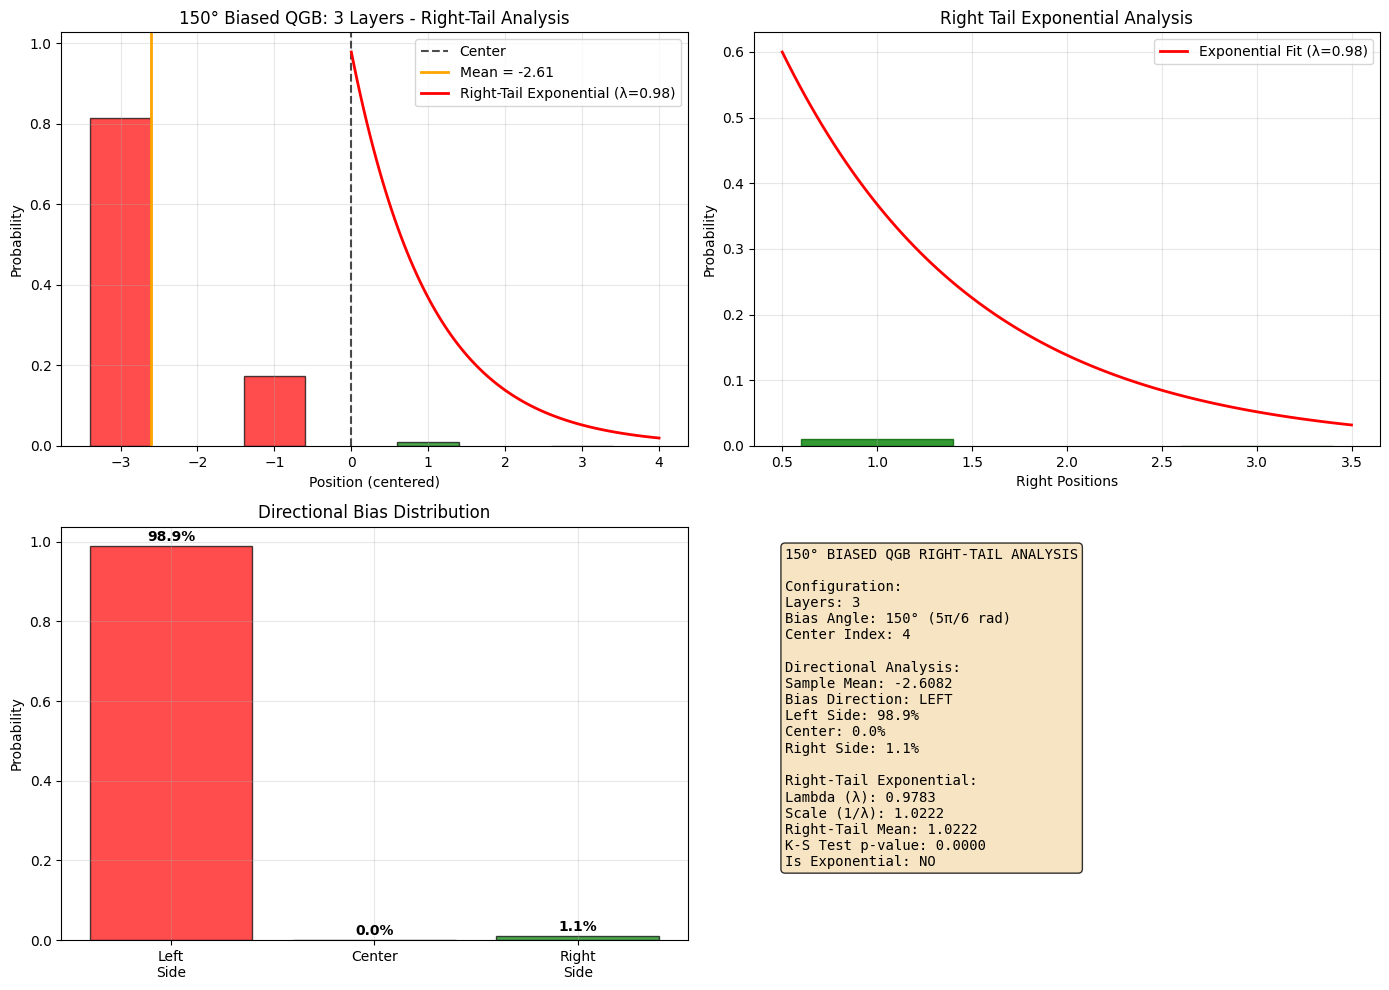


RESULTS:
Bias direction: LEFT
Sample mean: -2.6082
Right side probability: 1.1%
Left side probability: 98.9%
Right-tail exponential λ: 0.9783
K-S test p-value: 0.0000
Is exponential: NO

--------------------------------------------------
150° Biased QGB Analysis:
  Layers: 4
  Bias angle: 150° (5π/6 rad)
  Center index: 5

150° BIASED QGB RIGHT-TAIL EXPONENTIAL ANALYSIS
Layers: 4, Shots: 8192


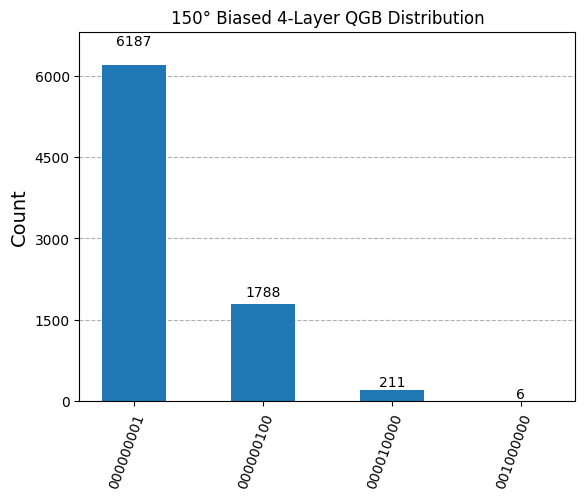

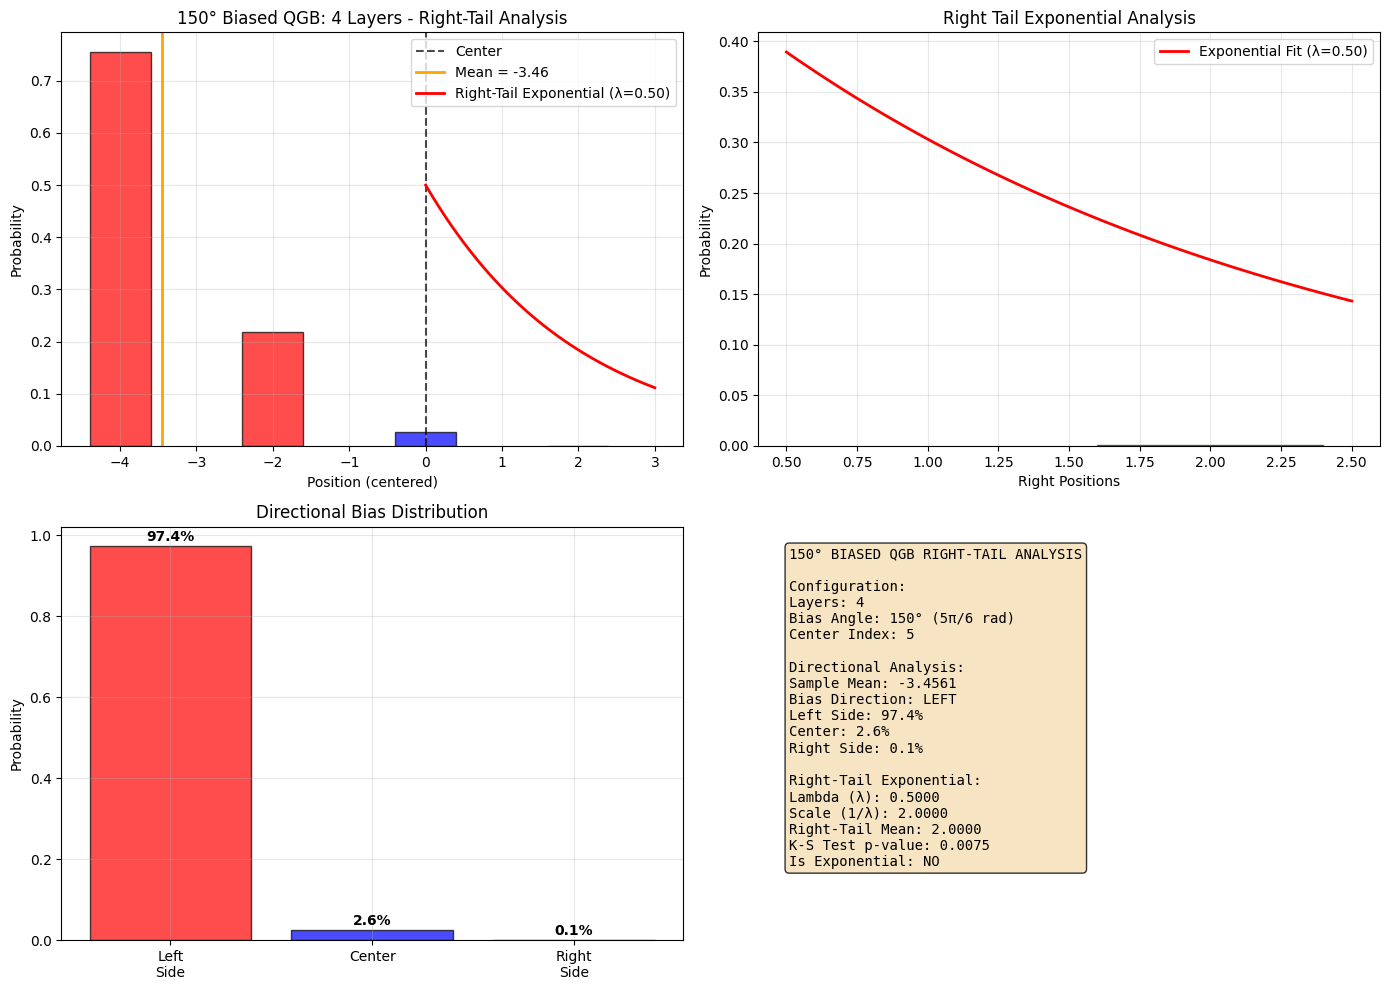


RESULTS:
Bias direction: LEFT
Sample mean: -3.4561
Right side probability: 0.1%
Left side probability: 97.4%
Right-tail exponential λ: 0.5000
K-S test p-value: 0.0075
Is exponential: NO

--------------------------------------------------
150° Biased QGB Analysis:
  Layers: 5
  Bias angle: 150° (5π/6 rad)
  Center index: 6

150° BIASED QGB RIGHT-TAIL EXPONENTIAL ANALYSIS
Layers: 5, Shots: 8192


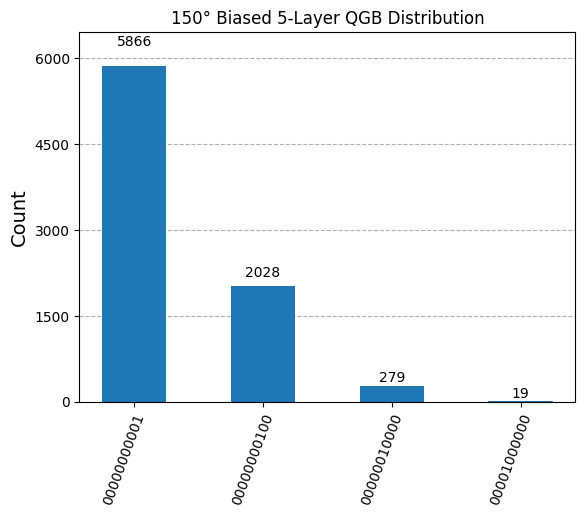

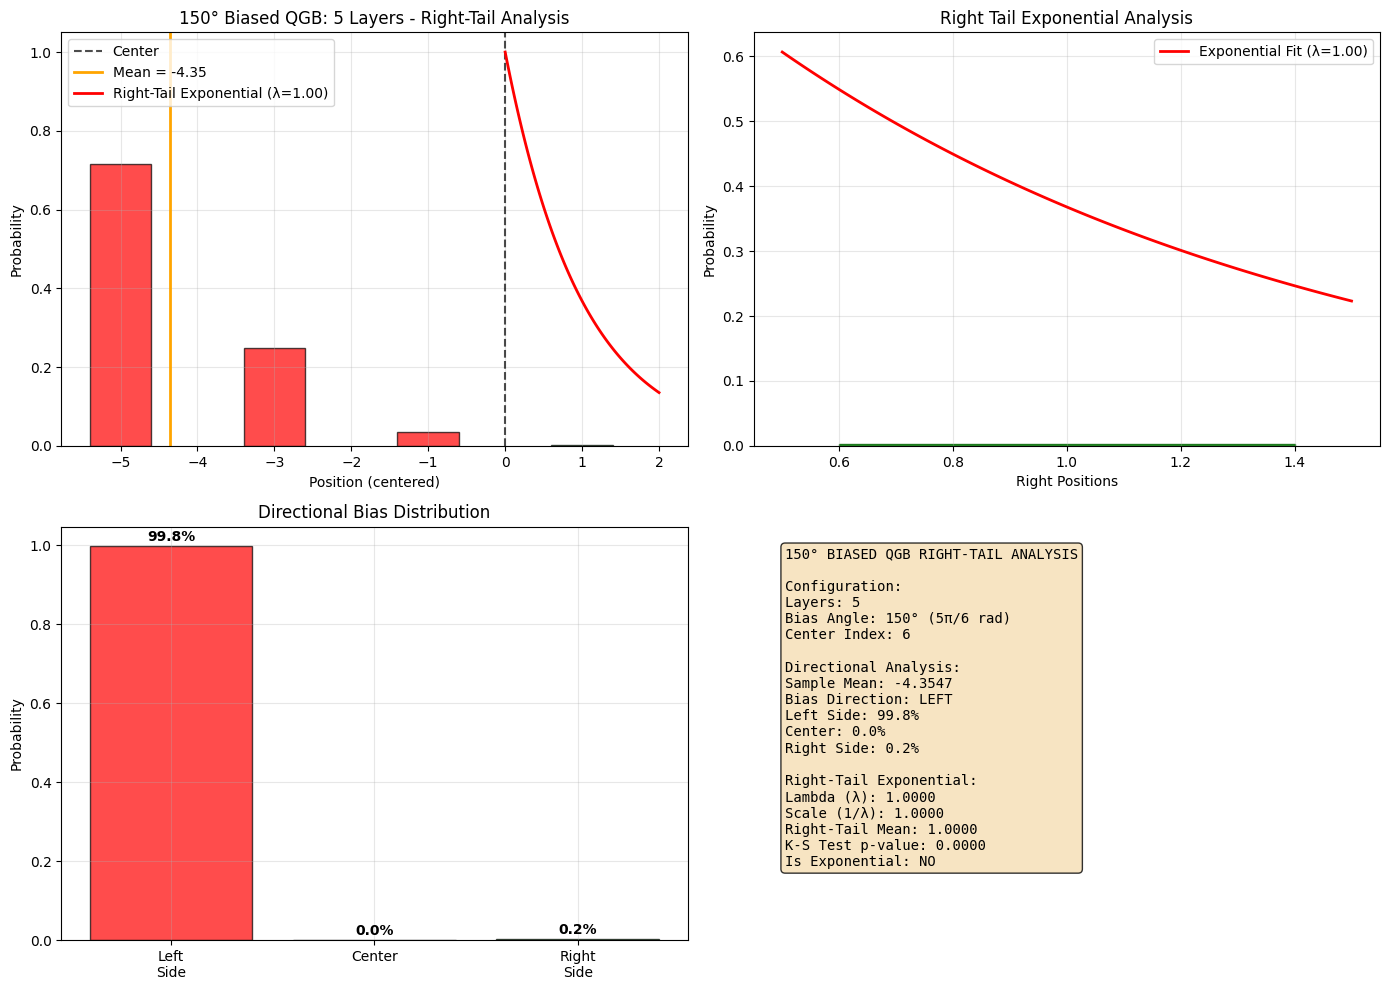


RESULTS:
Bias direction: LEFT
Sample mean: -4.3547
Right side probability: 0.2%
Left side probability: 99.8%
Right-tail exponential λ: 1.0000
K-S test p-value: 0.0000
Is exponential: NO

--------------------------------------------------
150° Biased QGB Analysis:
  Layers: 6
  Bias angle: 150° (5π/6 rad)
  Center index: 7

150° BIASED QGB RIGHT-TAIL EXPONENTIAL ANALYSIS
Layers: 6, Shots: 8192


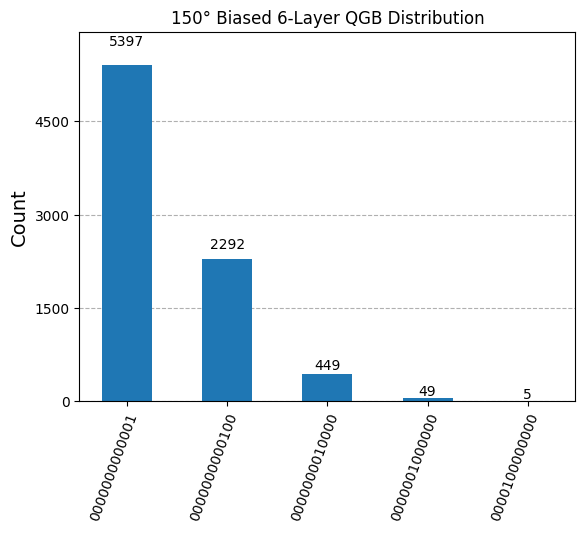

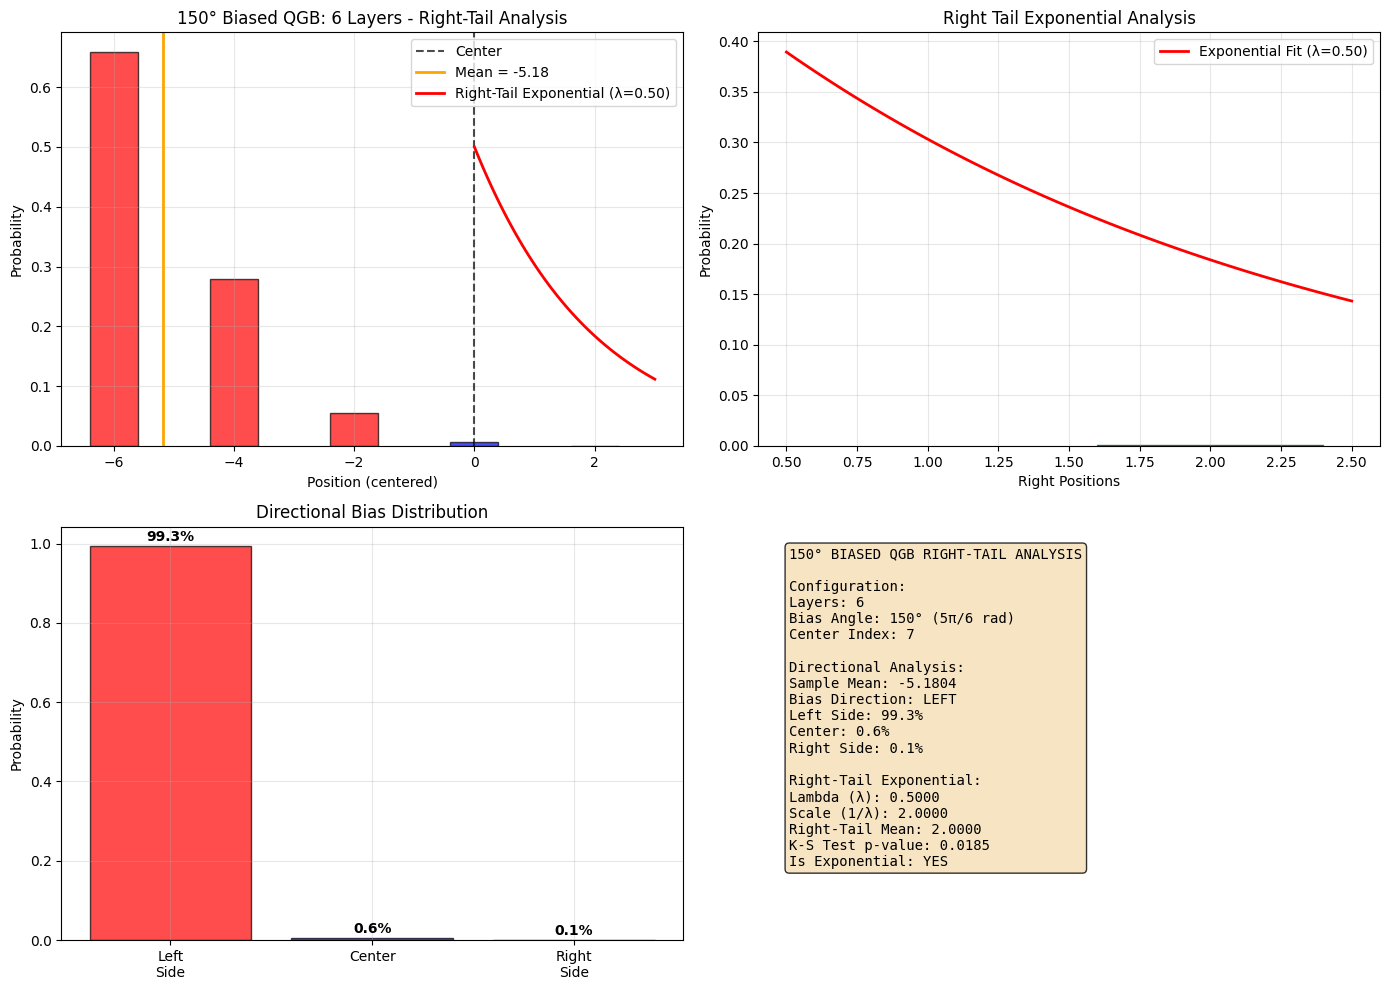


RESULTS:
Bias direction: LEFT
Sample mean: -5.1804
Right side probability: 0.1%
Left side probability: 99.3%
Right-tail exponential λ: 0.5000
K-S test p-value: 0.0185
Is exponential: YES

--------------------------------------------------
150° Biased QGB Analysis:
  Layers: 7
  Bias angle: 150° (5π/6 rad)
  Center index: 8

150° BIASED QGB RIGHT-TAIL EXPONENTIAL ANALYSIS
Layers: 7, Shots: 8192


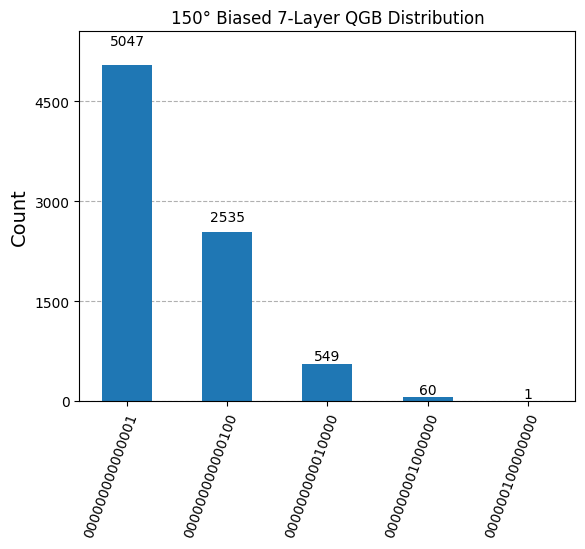

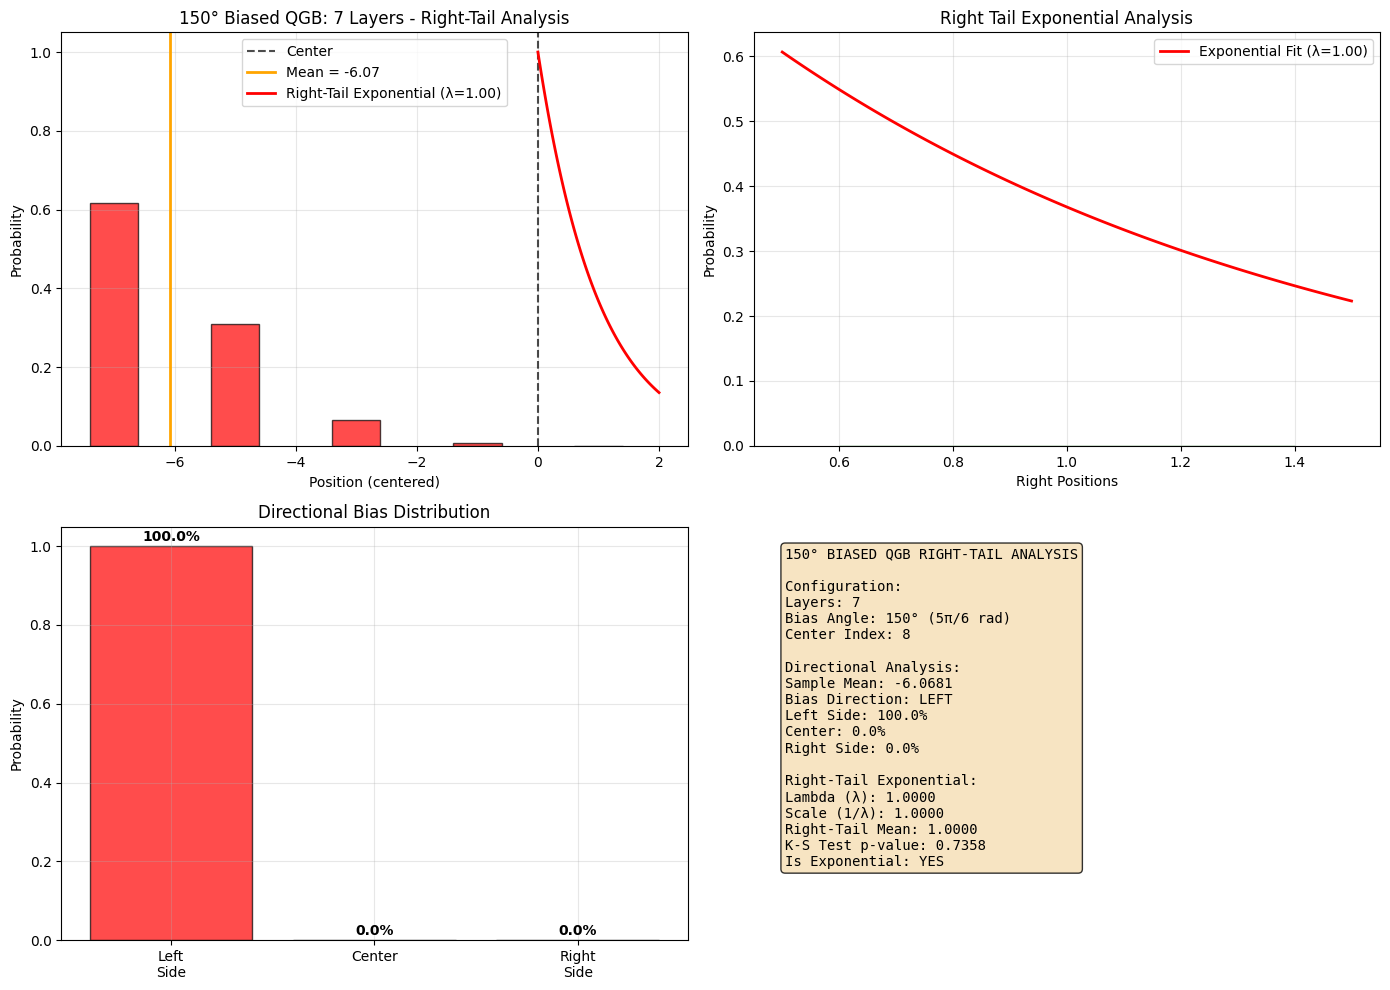


RESULTS:
Bias direction: LEFT
Sample mean: -6.0681
Right side probability: 0.0%
Left side probability: 100.0%
Right-tail exponential λ: 1.0000
K-S test p-value: 0.7358
Is exponential: YES

--------------------------------------------------
150° Biased QGB Analysis:
  Layers: 8
  Bias angle: 150° (5π/6 rad)
  Center index: 9

150° BIASED QGB RIGHT-TAIL EXPONENTIAL ANALYSIS
Layers: 8, Shots: 8192


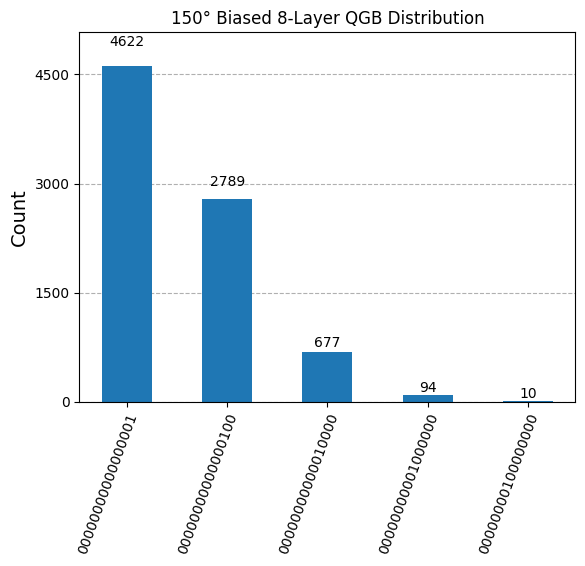

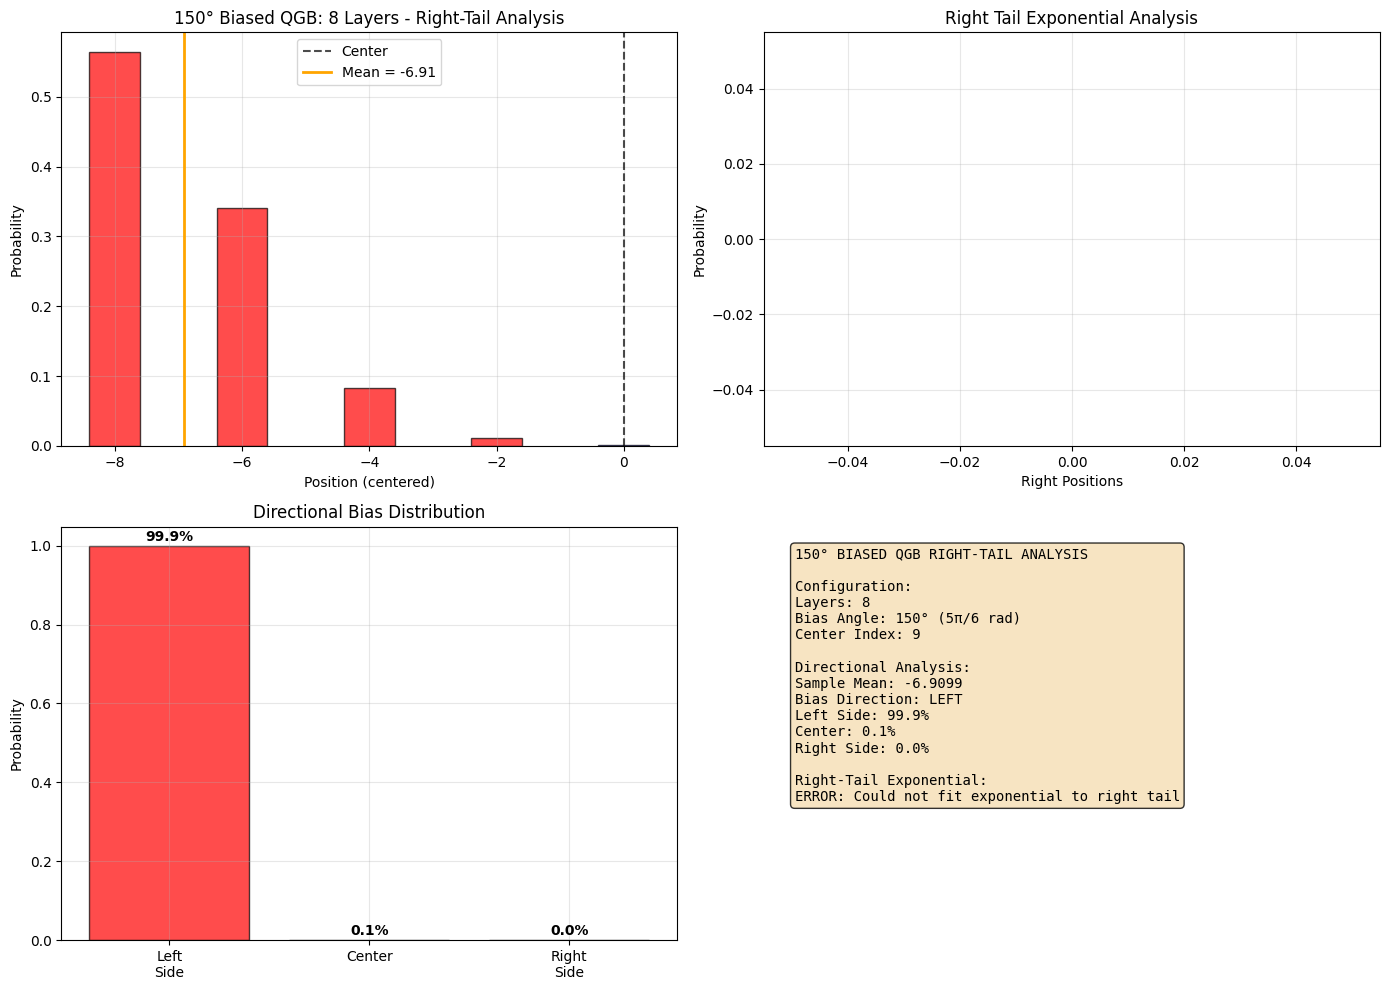


RESULTS:
Bias direction: LEFT
Sample mean: -6.9099
Right side probability: 0.0%
Left side probability: 99.9%

--------------------------------------------------


In [10]:


class BiasedQGB150Analyzer:
    """
    Streamlined analysis for 150° biased QGB - RIGHT-TAILED exponential distribution.
    """
    
    def __init__(self, n_layers, verbose=True):
        self.n_layers = n_layers
        self.theta = 5 * np.pi / 6  # Fixed at 150°
        self.verbose = verbose
        self.num_positions = 2 * n_layers + 1
        self.center_index = n_layers + 1
        
        if self.verbose:
            print(f"150° Biased QGB Analysis:")
            print(f"  Layers: {self.n_layers}")
            print(f"  Bias angle: 150° (5π/6 rad)")
            print(f"  Center index: {self.center_index}")
    
    def process_results(self, counts):
        """Process results preserving directional information."""
        position_counts = {}
        total_shots = sum(counts.values())
        
        for bitstring, count in counts.items():
            clean_bitstring = ''.join(c for c in bitstring if c in '01')
            if not clean_bitstring:
                continue
            
            position_index = None
            for i, bit in enumerate(reversed(clean_bitstring)):
                if bit == '1':
                    position_index = i + 1
                    break
            
            if position_index is not None:
                position_counts[position_index] = position_counts.get(position_index, 0) + count
        
        positions = np.array(sorted(position_counts.keys()))
        frequencies = np.array([position_counts[pos] for pos in positions])
        probabilities = frequencies / total_shots
        
        # CORRECTED: Center around 0 but preserve right-bias direction
        centered_positions = positions - self.center_index
        
        return centered_positions, frequencies, probabilities
    
    def analyze_right_tail(self, positions, frequencies, probabilities):
        """Analyze RIGHT-TAILED exponential distribution."""
        sample_mean = np.average(positions, weights=probabilities)
        
        # Separate right side (positive positions) for exponential analysis
        right_mask = positions > 0
        left_prob = np.sum(probabilities[positions < 0])
        right_prob = np.sum(probabilities[right_mask])
        center_prob = np.sum(probabilities[positions == 0])
        
        results = {
            'sample_mean': sample_mean,
            'left_probability': left_prob,
            'right_probability': right_prob,
            'center_probability': center_prob,
            'bias_direction': 'RIGHT' if sample_mean > 0.5 else 'LEFT' if sample_mean < -0.5 else 'CENTERED'
        }
        
        # Fit exponential to RIGHT tail only
        if np.any(right_mask):
            right_positions = positions[right_mask]
            right_frequencies = frequencies[right_mask]
            right_samples = np.repeat(right_positions, right_frequencies.astype(int))
            
            if len(right_samples) > 0:
                # Fit exponential distribution
                fitted_scale = stats.expon.fit(right_samples, floc=0)[1]
                fitted_lambda = 1 / fitted_scale
                
                # KS test for right tail
                ks_stat, ks_pvalue = stats.kstest(right_samples, 'expon', args=(0, fitted_scale))
                
                results.update({
                    'fitted_lambda': fitted_lambda,
                    'fitted_scale': fitted_scale,
                    'ks_pvalue': ks_pvalue,
                    'is_exponential': ks_pvalue > 0.01,
                    'right_tail_mean': np.mean(right_samples)
                })
        
        return results
    
    def create_plots(self, positions, probabilities, results):
        """Create visualization plots."""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 1: Distribution with directional coloring
        colors = ['red' if p < 0 else 'blue' if p == 0 else 'green' for p in positions]
        ax1.bar(positions, probabilities, alpha=0.7, color=colors, edgecolor='black', linewidth=1)
        
        ax1.axvline(0, color='black', linestyle='--', alpha=0.7, label='Center')
        ax1.axvline(results['sample_mean'], color='orange', linestyle='-', linewidth=2, 
                   label=f"Mean = {results['sample_mean']:.2f}")
        
        # Add exponential fit to right side if available
        if 'fitted_lambda' in results:
            x_right = np.linspace(0, max(positions) + 1, 100)
            exp_pdf = stats.expon.pdf(x_right, scale=results['fitted_scale'])
            ax1.plot(x_right, exp_pdf, 'r-', linewidth=2, 
                    label=f"Right-Tail Exponential (λ={results['fitted_lambda']:.2f})")
        
        ax1.set_xlabel('Position (centered)')
        ax1.set_ylabel('Probability')
        ax1.set_title(f'150° Biased QGB: {self.n_layers} Layers - Right-Tail Analysis')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Right tail focus
        ax2.bar(positions[positions > 0], probabilities[positions > 0], 
               alpha=0.8, color='green', edgecolor='darkgreen', linewidth=1)
        
        if 'fitted_lambda' in results:
            x_fit = np.linspace(0.5, max(positions[positions > 0]) + 0.5, 100)
            exp_fit = stats.expon.pdf(x_fit, scale=results['fitted_scale'])
            ax2.plot(x_fit, exp_fit, 'r-', linewidth=2, 
                    label=f"Exponential Fit (λ={results['fitted_lambda']:.2f})")
            ax2.legend()
        
        ax2.set_title('Right Tail Exponential Analysis')
        ax2.set_xlabel('Right Positions')
        ax2.set_ylabel('Probability')
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Bias distribution
        bias_labels = ['Left\nSide', 'Center', 'Right\nSide']
        bias_values = [results['left_probability'], results['center_probability'], results['right_probability']]
        bias_colors = ['red', 'blue', 'green']
        
        bars = ax3.bar(bias_labels, bias_values, color=bias_colors, alpha=0.7, edgecolor='black')
        ax3.set_ylabel('Probability')
        ax3.set_title('Directional Bias Distribution')
        ax3.grid(True, alpha=0.3)
        
        for bar, value in zip(bars, bias_values):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                    f'{value:.1%}', ha='center', va='bottom', fontweight='bold')
        
        # Plot 4: Statistics summary
        stats_text = f"""150° BIASED QGB RIGHT-TAIL ANALYSIS

Configuration:
Layers: {self.n_layers}
Bias Angle: 150° (5π/6 rad)
Center Index: {self.center_index}

Directional Analysis:
Sample Mean: {results['sample_mean']:.4f}
Bias Direction: {results['bias_direction']}
Left Side: {results['left_probability']:.1%}
Center: {results['center_probability']:.1%}
Right Side: {results['right_probability']:.1%}

Right-Tail Exponential:"""
        
        if 'fitted_lambda' in results:
            stats_text += f"""
Lambda (λ): {results['fitted_lambda']:.4f}
Scale (1/λ): {results['fitted_scale']:.4f}
Right-Tail Mean: {results['right_tail_mean']:.4f}
K-S Test p-value: {results['ks_pvalue']:.4f}
Is Exponential: {'YES' if results['is_exponential'] else 'NO'}"""
        else:
            stats_text += "\nERROR: Could not fit exponential to right tail"
        
        ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        ax4.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def run_analysis(self, shots=8192, plot=True):
        """Run complete 150° biased QGB analysis."""
        print(f"\n{'='*60}")
        print(f"150° BIASED QGB RIGHT-TAIL EXPONENTIAL ANALYSIS")
        print(f"{'='*60}")
        print(f"Layers: {self.n_layers}, Shots: {shots}")
        
        # Generate circuit
        qc = n_layer_biased_qgb(n_layers=self.n_layers, theta=self.theta)
        
        # Simulate
        sim = AerSimulator()
        compiled = transpile(qc, sim)
        result = sim.run(compiled, shots=shots).result()
        counts = result.get_counts()
        
        if plot:
            plot_histogram(counts)
            plt.title(f"150° Biased {self.n_layers}-Layer QGB Distribution")
            plt.show()
        
        # Process and analyze
        positions, frequencies, probabilities = self.process_results(counts)
        verification = self.analyze_right_tail(positions, frequencies, probabilities)
        
        if plot:
            self.create_plots(positions, probabilities, verification)
        
        # Print results
        print(f"\nRESULTS:")
        print(f"Bias direction: {verification['bias_direction']}")
        print(f"Sample mean: {verification['sample_mean']:.4f}")
        print(f"Right side probability: {verification['right_probability']:.1%}")
        print(f"Left side probability: {verification['left_probability']:.1%}")
        
        if 'fitted_lambda' in verification:
            print(f"Right-tail exponential λ: {verification['fitted_lambda']:.4f}")
            print(f"K-S test p-value: {verification['ks_pvalue']:.4f}")
            print(f"Is exponential: {'YES' if verification['is_exponential'] else 'NO'}")
        else:
            print("Warning: Could not fit exponential to right tail")
        
        return {
            'qc': qc, 'counts': counts, 'positions': positions,
            'frequencies': frequencies, 'probabilities': probabilities,
            'verification': verification
        }

def n_layer_biased_qgb(n_layers, theta):
    """Biased QGB circuit implementation."""
    num_positions = 2 * n_layers + 1
    total_qubits = num_positions + 1
    qc = QuantumCircuit(total_qubits, num_positions)
    
    coin = 0
    center = n_layers + 1
    qc.x(center)
    
    for k in range(1, n_layers + 1):
        qc.rx(theta, coin)
        pairs = [(j, j + 1) for j in range(center - k, center + k)]
        for i, (a, b) in enumerate(pairs):
            qc.append(CSwapGate(), [coin, a, b])
            if i < len(pairs) - 1:
                qc.cx(b, coin)
        if k < n_layers:
            qc.reset(coin)
    
    for i, pos in enumerate(range(1, num_positions + 1)):
        qc.measure(pos, i)
    
    return qc

# USAGE:
if __name__ == "__main__":
    # Analyze 150° biased QGB for different layer counts
    for layers in [3, 4, 5, 6, 7, 8]:
        analyzer = BiasedQGB150Analyzer(n_layers=layers, verbose=True)
        result = analyzer.run_analysis(shots=8192, plot=True)
        print(f"\n{'-'*50}")


##  b. Hadamard quantum walk ##

In [11]:

def build_qgb(n_layers: int, measure_all_positions: bool = True):
    """
    Hadamard coined quantum walk on a finite line segment encoded as one-hot over q[1..2n+1].
    Per step:
      - H on coin
      - Conditional shift: coin=0 -> left by 1, coin=1 -> right by 1
    Reflecting boundaries (no wrap).
    Keeps the same interface/signature as your original function.
    """
    if n_layers < 1:
        raise ValueError("n_layers must be >= 1")

    num_positions = 2*n_layers + 1
    total_qubits  = num_positions + 1  # coin + positions
    qc = QuantumCircuit(total_qubits, num_positions)

    coin   = 0
    left   = 1
    right  = num_positions
    center = n_layers + 1

    # Initialize walker at center
    qc.x(center)

    # Helper: controlled swap with coin control=|1> and with |0> control via X coin
    def cswap_coin1(a, b):
        qc.cswap(coin, a, b)

    def cswap_coin0(a, b):
        qc.x(coin)
        qc.cswap(coin, a, b)
        qc.x(coin)

    for _ in range(n_layers):
        # Coin toss
        qc.h(coin)

        # Shift right by 1 if coin=1:
        # Move the '1' one step to the right using a rightward swap cascade
        # Order: swap (right-1,right), (right-2,right-1), ..., (center, center+1), ..., (left, left+1)
        for i in range(right-1, left-1, -1):
            cswap_coin1(i, i+1)

        # Shift left by 1 if coin=0:
        # Move the '1' one step to the left using a leftward swap cascade
        # Order: swap (left,left+1), (left+1,left+2), ..., (center-1,center), ..., (right-1,right)
        for i in range(left, right):
            cswap_coin0(i, i+1)

    # Measure one-hot position register
    if measure_all_positions:
        for c, q in enumerate(range(1, num_positions+1)):
            qc.measure(q, c)

    return qc

def simulate_qgb(n_layers: int, shots: int = 4096, measure_all_positions: bool = True, plot: bool = True):
    qc = build_qgb(n_layers, measure_all_positions=measure_all_positions)

    # Draw
    qc.draw(output='mpl', style='clifford', fold=1)
    plt.title(f"Hadamard Coined Quantum Walk Circuit ({n_layers} steps)")
    plt.show()

    sim = AerSimulator()
    # Safe path: run without backend-aware target rebuild
    result = sim.run(qc, shots=shots).result()
    counts = result.get_counts()

    if plot:
        # Convert one-hot bitstrings to centered positions
        num_positions = 2*n_layers + 1
        center = n_layers + 1
        total = sum(counts.values())
        pos_counts = {}
        for b, c in counts.items():
            bs = ''.join(ch for ch in b if ch in '01')
            pos_idx = None
            for i, bit in enumerate(reversed(bs)):  # cbits map reversed to q[1..]
                if bit == '1':
                    pos_idx = i + 1
                    break
            if pos_idx is not None:
                pos_counts[pos_idx-center] = pos_counts.get(pos_idx-center, 0) + c

        xs = sorted(pos_counts.keys())
        ys = [pos_counts[x]/total for x in xs]

        # Clean interference-style plot (no bar labels)
        fig, ax = plt.subplots(figsize=(10,5))
        ax.bar(xs, ys, color='royalblue', edgecolor='navy', alpha=0.85)
        ax.plot(xs, ys, 'o-', color='crimson', linewidth=2, alpha=0.7)
        ax.axvline(0, color='black', linestyle='--', alpha=0.5)
        ax.set_xlabel('Position (centered)')
        ax.set_ylabel('Probability')
        ax.set_title(f'Hadamard Quantum Walk Distribution ({n_layers} steps)')
        ax.grid(True, alpha=0.25)
        plt.tight_layout()
        plt.show()

    return qc, counts


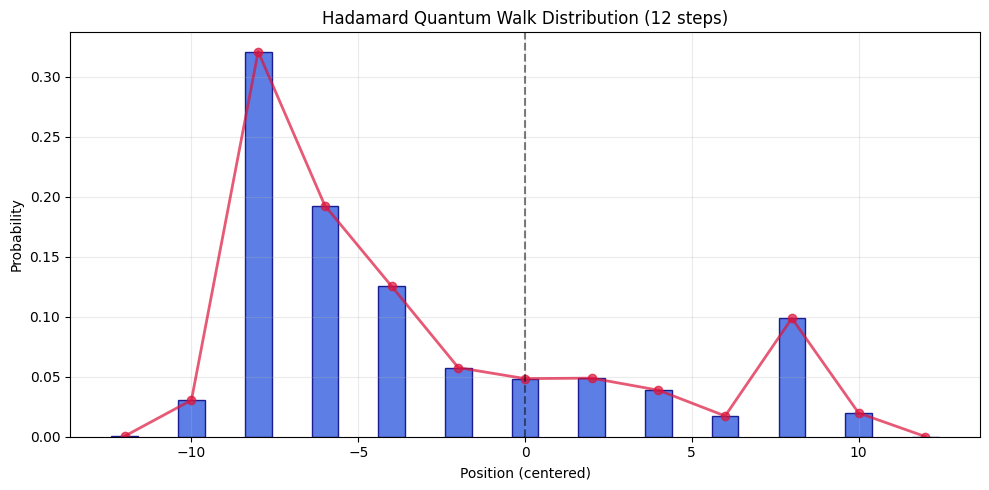

In [12]:
qc, counts = simulate_qgb(12, shots=20000, plot=True)